# **GCN+LSTM модель для анализа поведения пользователей**

### Загрузка данных:
* Загружаются данные из CSV-файлов, включая информацию об узлах, рёбрах и ресурсах.
* Для узлов (пользователей) извлекаются такие признаки, как роль пользователя, количество логинов, уровень доступа и время с последнего входа.
* Для ресурсов вычисляются дополнительные признаки, такие как тип ресурса и уровень доступа.

In [134]:
import pandas as pd

# Пути к файлам
nodes_path = "data/nodes.csv"
resources_path = "data/resources.csv"
edges_path = "data/edges.csv"

# Загрузка данных
nodes_df = pd.read_csv(nodes_path)
resources_df = pd.read_csv(resources_path)
edges_df = pd.read_csv(edges_path, parse_dates=["timestamp"])

# Убедимся, что timestamp — это datetime
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')


In [135]:
import numpy as np

# Параметры

start_hour = 9
end_hour = 18

offset = len(nodes_df)

# Определение нерабочего времени
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')
edges_df['is_after_hours'] = (
    (edges_df['timestamp'].dt.hour < start_hour) |
    (edges_df['timestamp'].dt.hour >= end_hour) |
    (edges_df['timestamp'].dt.weekday >= 5)
)
after_hours_edges = set([
    (row['source_user'], row['target_resource'] + offset)
    for _, row in edges_df[edges_df['is_after_hours']].iterrows()
])

# Преобразование timestamp в Unix-время
edges_df['timestamp_unix'] = edges_df['timestamp'].astype('int64') // 10**9  # В секундах


In [136]:
from sklearn.preprocessing import LabelEncoder
import torch

#IN_CHANNELS_MODEL = ['role_encoded', 'login_count', 'access_level', 'session_time', 'days_since_login']
IN_CHANNELS_MODEL = ['role_encoded', 'access_level']
#ADD_FEATURES = ['resource_type_encoded', 'importance', 'access_level']
ADD_FEATURES = ['resource_type_encoded', 'importance']

# Кодирование признаков узлов
role_encoder = LabelEncoder()
nodes_df['role_encoded'] = role_encoder.fit_transform(nodes_df['role'])
# Признаки Время последнего входа → дни
nodes_df['last_login_time'] = pd.to_datetime(nodes_df['last_login_time'])
ref_date = pd.Timestamp("2025-05-18")
nodes_df['days_since_login'] = (ref_date - nodes_df['last_login_time']).dt.days
# Признаки пользователей
user_features = nodes_df[IN_CHANNELS_MODEL].values

In [137]:
# Кодирование признаков узлов (ресурсы)
resource_encoder = LabelEncoder()
# Обработка ресурсов
resources_df['resource_type_encoded'] = resource_encoder.fit_transform(resources_df['resource_type'])
# Реальные признаки ресурсов
base_resource_features = resources_df[ADD_FEATURES].values
# Дополняем признаки ресурсов двумя нулями (чтобы было 6 признаков, как у пользователей)
#resource_features_padded = np.hstack([base_resource_features, np.zeros((base_resource_features.shape[0], 3))])
resource_features_padded = np.hstack([base_resource_features, np.zeros((base_resource_features.shape[0], user_features.shape[1]-base_resource_features.shape[1]))])
# Объединяем признаки пользователей и ресурсов
x_combined = np.vstack([user_features, resource_features_padded])

In [138]:
base_resource_features

array([[1, 1],
       [1, 2],
       [4, 3],
       [0, 4],
       [2, 1],
       [1, 2],
       [1, 4],
       [4, 3],
       [4, 3],
       [1, 4],
       [3, 3],
       [5, 3]])

In [139]:
resource_features_padded

array([[1., 1.],
       [1., 2.],
       [4., 3.],
       [0., 4.],
       [2., 1.],
       [1., 2.],
       [1., 4.],
       [4., 3.],
       [4., 3.],
       [1., 4.],
       [3., 3.],
       [5., 3.]])

In [140]:
# Cоздается тензор (многомерный массив) из данных x_combined
# Этот тензор x будет использоваться как входные данные для GCN (Graph Convolutional Network) части модели
x = torch.tensor(x_combined, dtype=torch.float)

In [141]:
# Переменная offset будет использоваться для корректной индексации узлов-ресурсов
#offset = len(user_features)
# Извлекаем столбец source_user из DataFrame edges_df (источники рёбер - пользователи), преобразуем значения в целые числа и получает NumPy массив
sources = edges_df['source_user'].astype(int).values
# Извлекаем столбец target_resource (цели рёбер - ресурсы), преобразуем в целые числа и получает NumPy массив
targets = edges_df['target_resource'].astype(int).values + offset
# Объединяем в edge_index [2, num_edges]
edge_index_np = np.vstack([sources, targets])
edge_index = torch.tensor(edge_index_np, dtype=torch.long)

In [142]:
y = torch.tensor(nodes_df['role_encoded'].values, dtype=torch.long)

In [143]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

In [144]:
num_users = y.shape[0]
# Обучающая маска — используем только узлы-пользователи.
# Только пользователи имеют известные метки (y).
# Ресурсы — это объекты взаимодействия, и они участвуют в обучении опосредованно через связи (рёбра), но не обучаются напрямую как целевые точки.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:num_users] = True

In [145]:
# Добавим фиктивные метки для ресурсов
num_resources = resource_features_padded.shape[0]
y_full = np.concatenate([y, -1 * np.ones(num_resources)])  # -1 — метка для нерелевантных узлов

# Сконвертируем
data.y = torch.tensor(y_full, dtype=torch.long)

## Загрузка и подготовка тестовых данных GCN

In [146]:
# === Загрузка тестовых данных ===
nodes_test = pd.read_csv("data/nodes_test.csv")
edges_test = pd.read_csv("data/edges_test.csv")
resources_test = pd.read_csv("data/resources_test.csv")

edges_test['timestamp'] = pd.to_datetime(edges_test['timestamp'], errors='coerce')
# Кодирование признаков узлов
nodes_test['role_encoded'] = role_encoder.transform(nodes_test['role'])
# Признаки Время последнего входа → дни
nodes_test['last_login_time'] = pd.to_datetime(nodes_test['last_login_time'])
nodes_test['days_since_login'] = (ref_date - nodes_test['last_login_time']).dt.days
# Признаки пользователей
x_test_users = nodes_test[IN_CHANNELS_MODEL].to_numpy()
# Обработка ресурсов ---
resources_test['resource_type_encoded'] = resource_encoder.transform(resources_test['resource_type'])
# Реальные признаки ресурсов
x_test_resources = resources_test[ADD_FEATURES].to_numpy()
# Дополняем признаки ресурсов двумя нулями (чтобы было 6 признаков, как у пользователей)
x_test_resources_padded = np.hstack([x_test_resources, np.zeros((x_test_resources.shape[0], x_test_users.shape[1] - x_test_resources.shape[1]))])

#num_users_test = x_test_users.shape[0]
#num_resources_test = x_test_resources.shape[0]
#x_test_resources_padded = np.zeros((num_resources_test, x_test_users.shape[1]))

# Объединяем признаки пользователей и ресурсов
x_test_combined = np.vstack([x_test_users, x_test_resources_padded])
num_test_users = x_test_users.shape[0]
sources_test = edges_test['source_user'].astype(int).values
offset = len(nodes_test)
targets_test = edges_test['target_resource'].astype(int).values + offset
edge_index_test_np = np.vstack([sources_test, targets_test])
edge_index_test = torch.tensor(edge_index_test_np, dtype=torch.long)

test_data = Data(x=torch.tensor(x_test_combined, dtype=torch.float), edge_index=edge_index_test)

# Метки и размерность
y_test = torch.tensor(nodes_test['role_encoded'].values, dtype=torch.long)
num_test_users = len(y_test)  # Автоматически устанавливаем правильное значение

## Подготовка данных для модели LSTM

In [147]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
unique_resources = sorted(set(edges_df['target_resource']))
resource_map = {rid: idx for idx, rid in enumerate(unique_resources)}
resource_features = scaler.fit_transform(resources_df[['importance']])

In [148]:
# LSTM часть: последовательности действий
LSTM_FEATURES = ['hour', 'dayofweek', 'event_type_id']


def normalization_data(edges_df):

    edges_df = edges_df.dropna(subset=['event_type'])
    edges_df['event_type_id'] = LabelEncoder().fit_transform(edges_df['event_type'])
    edges_df['hour'] = edges_df['timestamp'].dt.hour
    edges_df['dayofweek'] = edges_df['timestamp'].dt.dayofweek
    edges_df['hour'] = edges_df['hour'].fillna(edges_df['hour'].mean())
    edges_df['dayofweek'] = edges_df['dayofweek'].fillna(edges_df['dayofweek'].mean())
    return edges_df

def get_lstm_input_tensor(edges_df):
    sequences = []
    user_ids = sorted(edges_df['source_user'].unique())
    for user_id in user_ids:
        user_seq = edges_df[edges_df['source_user'] == user_id].sort_values('timestamp')[LSTM_FEATURES].values
        sequences.append(user_seq)
    max_len = max(len(seq) for seq in sequences)
    num_features = len(LSTM_FEATURES)
    padded = np.zeros((len(sequences), max_len, num_features))
    for i, seq in enumerate(sequences):
        padded[i, :len(seq), :] = seq
    return torch.tensor(padded, dtype=torch.float), num_features

edges_df = normalization_data(edges_df)
lstm_input_tensor, num_features = get_lstm_input_tensor(edges_df)

#===========================================================
edges_test = normalization_data(edges_test)
lstm_input_tensor_test, num_features_test = get_lstm_input_tensor(edges_test)

#=============================================================
edge_attr = []
for idx, row in edges_df.iterrows():
    res_idx = resource_map.get(row['target_resource'], None)
    if res_idx is not None:
        feature_value = float(resource_features[res_idx])
        original_attrs = [row['hour'], row['dayofweek'], row['event_type_id']]
        new_attrs = original_attrs + [feature_value]
        edge_attr.append(new_attrs)

# Приводим к нужному формату
edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)



/tmp/ipykernel_1177285/446452995.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_value = float(resource_features[res_idx])


## Модель GCN

In [149]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# --- Модель GCN ---
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


## Гибридная модель

In [150]:
import torch.nn as nn

# === Гибридная модель ===
class GCN_LSTM_Hybrid(nn.Module):
    def __init__(self, gcn_in, gcn_hidden, lstm_in, lstm_hidden, out_dim):
        super().__init__()
        self.gcn = GCNConv(gcn_in, gcn_hidden)
        self.lstm = nn.LSTM(input_size=lstm_in, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(gcn_hidden + lstm_hidden, out_dim)

    def forward(self, data, sequences):
        x_gcn = F.relu(self.gcn(data.x, data.edge_index))

        x_users = x_gcn[:sequences.size(0)]
        lstm_out, _ = self.lstm(sequences)
        lstm_last = lstm_out[:, -1, :]
        combined = torch.cat([x_users, lstm_last], dim=1)

        return self.fc(combined)

## Обучение

In [151]:
class Trainer:
    def __init__(self, model, data, optimizer, criterion):
        self.model = model
        self.data = data
        self.optimizer = optimizer
        self.criterion = criterion

    def train_gcn(self):
        self.model.train()
        self.optimizer.zero_grad()
        out = self.model(self.data)
        loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_gcn_lstm(self,lstm_input_tensor):

        self.model.train()
        self.optimizer.zero_grad()
        out = self.model(self.data, lstm_input_tensor)
        loss = self.criterion(out[:num_users], self.data.y[self.data.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss.item()


## Предсказание на новых данных

In [152]:
# === Предсказание на новых данных ===
class Tester:
    def __init__(self, model, test_data, y, num_test_users):
        """
        model: обученная модель (GCN или GCN+LSTM)
        test_data: данные в формате PyTorch Geometric Data
        y: истинные метки классов (тензор)
        num_test_users: количество узлов-пользователей в тестовой выборке
        """
        self.model = model
        self.test_data = test_data
        self.y = y
        self.num_test_users = num_test_users

    def test_gcn(self):
        self.model.eval()

        with torch.no_grad():
            out = self.model(self.test_data)

            preds = out.argmax(dim=1)
            test_preds = preds[:self.num_test_users]
            correct = (test_preds == self.y[:self.num_test_users]).sum()
            acc = float(correct) / len(test_preds)

        return acc

    def test_gcn_lstm(self, lstm_input_tensor):
        self.model.eval()

        with torch.no_grad():
            out = self.model(self.test_data, lstm_input_tensor)

            preds = out.argmax(dim=1)
            test_preds = preds[:self.num_test_users]
            correct = (test_preds == self.y[:self.num_test_users]).sum()
            acc = float(correct) / len(test_preds)

        return acc


In [153]:
GCN_HIDDEN_CHANNELS = 16
LSTM_HIDDEN_CHANNELS = 32
MAX_EPOCHS = 101
GCN_IN_CHANNELS = x.shape[1]
LSTM_IN_CHANNELS = num_features



In [154]:
# Инициализация и обучение
model = GCN(in_channels=GCN_IN_CHANNELS, hidden_channels=GCN_HIDDEN_CHANNELS, out_channels=len(torch.unique(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

data.edge_attr = edge_attr_tensor

trainer = Trainer(model, data, optimizer, criterion)
y_test = torch.tensor(nodes_test['role_encoded'].values, dtype=torch.long)
num_test_users = len(y_test)
tester = Tester(model, test_data, y_test, num_test_users)

In [155]:
losses_gcn = []
accuracies_gcn = []

for epoch in range(1, MAX_EPOCHS):

    loss_gcn = trainer.train_gcn()
    losses_gcn.append(loss_gcn)

    acc_gcn = tester.test_gcn()
    accuracies_gcn.append(acc_gcn)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Эпоха {epoch:03d}: Потери: {loss_gcn:.4f}, Тестирование (Точность): {acc_gcn:.4f}")

Эпоха 001: Потери: 1.9921, Тестирование (Точность): 0.2000
Эпоха 010: Потери: 1.3130, Тестирование (Точность): 0.6000
Эпоха 020: Потери: 1.0538, Тестирование (Точность): 0.7000
Эпоха 030: Потери: 0.8235, Тестирование (Точность): 0.7000
Эпоха 040: Потери: 0.6713, Тестирование (Точность): 0.8500
Эпоха 050: Потери: 0.5575, Тестирование (Точность): 0.8500
Эпоха 060: Потери: 0.4746, Тестирование (Точность): 0.8500
Эпоха 070: Потери: 0.4082, Тестирование (Точность): 0.8500
Эпоха 080: Потери: 0.3563, Тестирование (Точность): 0.8500
Эпоха 090: Потери: 0.3156, Тестирование (Точность): 0.8500
Эпоха 100: Потери: 0.2826, Тестирование (Точность): 0.9500


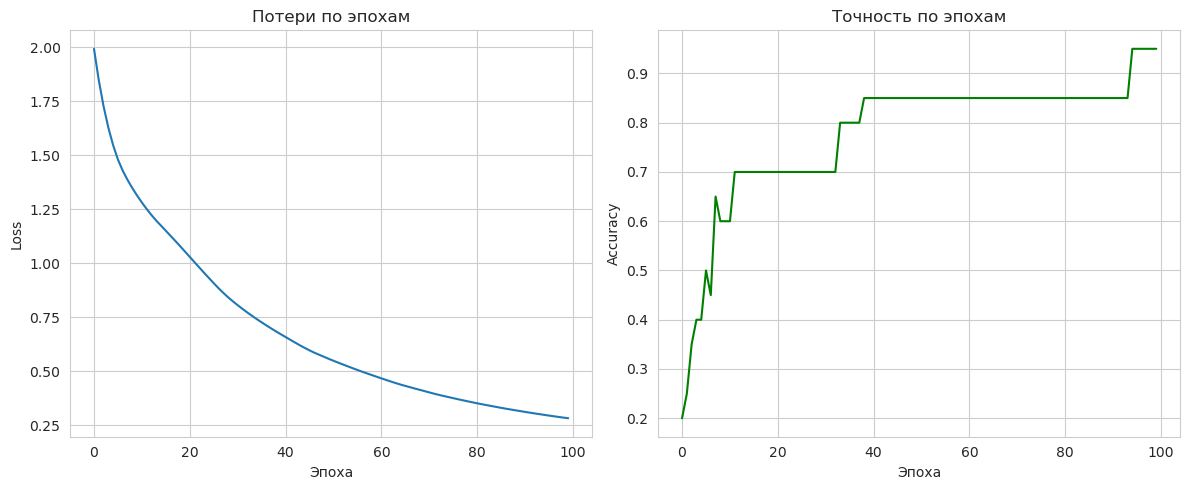

In [156]:
#Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_gcn, label='Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies_gcn, label='Accuracy', color='green')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def evaluate_with_confusion_matrix_gcn(model, data, y_true, num_test_users, class_labels=None):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1)
        test_preds = preds[:num_test_users].cpu().numpy()
        y_test_true = y_true[:num_test_users].cpu().numpy()
        cm = confusion_matrix(y_test_true, test_preds)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title("Confusion Matrix of the GCN")
        plt.tight_layout()
        plt.show()

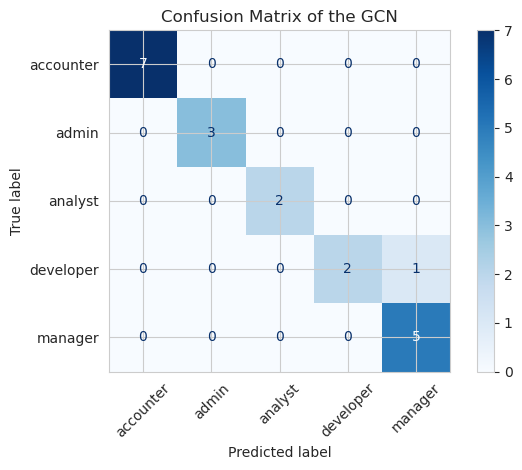

In [158]:
class_labels = list(role_encoder.classes_)
evaluate_with_confusion_matrix_gcn(model, data, y_test, num_test_users, class_labels)

In [159]:
# Инициализация модели
model = GCN_LSTM_Hybrid(
    gcn_in=GCN_IN_CHANNELS,
    gcn_hidden=GCN_HIDDEN_CHANNELS,# login_count, access_level, var_activity
    lstm_in=LSTM_IN_CHANNELS,  # weight и timestamp_unix
    lstm_hidden=LSTM_HIDDEN_CHANNELS,
    out_dim=len(torch.unique(y))
)

# Обучение
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

trainer = Trainer(model, data, optimizer, criterion)

y_test = torch.tensor(nodes_test['role_encoded'].values, dtype=torch.long)
num_test_users = len(y_test)
tester = Tester(model, test_data, y_test, num_test_users)

In [160]:
losses_gcn_lstm = []
accuracies_gcn_lstm = []
for epoch in range(1, MAX_EPOCHS):

    loss_gcn_lstm = trainer.train_gcn_lstm(lstm_input_tensor)
    losses_gcn_lstm.append(loss_gcn_lstm)

    acc_gcn_lstm = tester.test_gcn_lstm(lstm_input_tensor_test)
    accuracies_gcn_lstm.append(acc_gcn_lstm)

    if epoch % 10 == 0 or epoch == 1:
print(f"f"Эпоха {epoch:03d}: {Потери: {loss_gcn_lstm:.4f}:.4f}")

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (19096459.py, line 12)

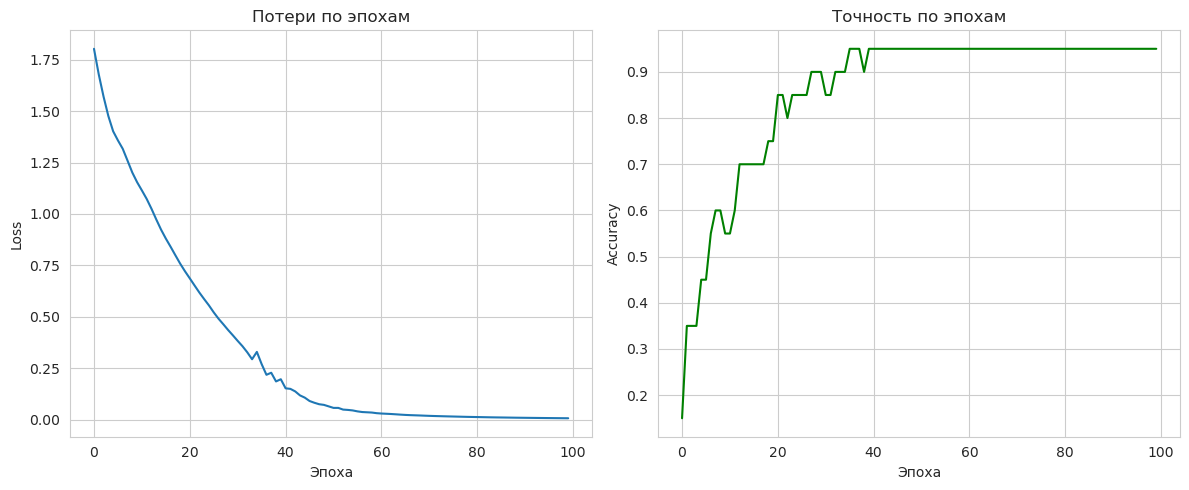

In [142]:
#Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_gcn_lstm, label='Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies_gcn_lstm, label='Accuracy', color='green')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

In [143]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f1_list = []

def evaluate_with_confusion_matrix_gcn_lstm(model, data, lstm_input_tensor, y_true, num_test_users, class_labels=None):
    model.eval()
    with torch.no_grad():
        out = model(data, lstm_input_tensor)
        preds = out.argmax(dim=1)
        test_preds = preds[:num_test_users].cpu().numpy()
        y_test_true = y_true[:num_test_users].cpu().numpy()
        cm = confusion_matrix(y_test_true, test_preds)
        f1 = f1_score(y_test_true, test_preds, average='weighted')
        f1_list.append(f1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix of GCN+LSTM")
        plt.show()

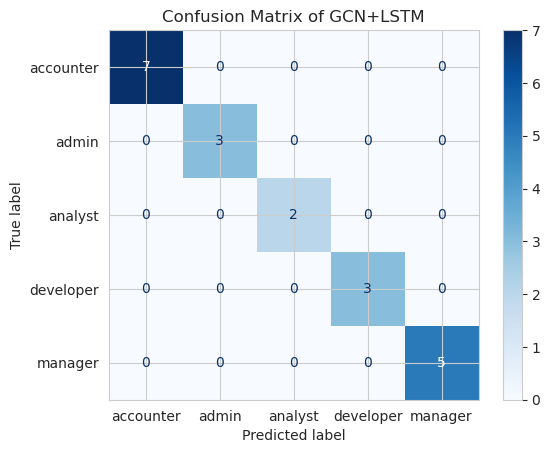

In [144]:
class_labels = list(role_encoder.classes_)
evaluate_with_confusion_matrix_gcn_lstm(model, data, lstm_input_tensor, y, num_test_users, class_labels)

In [145]:
f1_list

[1.0]

In [146]:
import networkx as nx
from matplotlib.colors import ListedColormap

# Инициализация и обучение
#model = GCN(in_channels=GCN_IN_CHANNELS, hidden_channels=GCN_HIDDEN_CHANNELS, out_channels=len(torch.unique(y)))
#optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
#criterion = torch.nn.CrossEntropyLoss()

#trainer = Trainer(model, data, optimizer, criterion)
#y_test = torch.tensor(nodes_test['role_encoded'].values, dtype=torch.long)
#tester = Tester(model, test_data, y_test, num_test_users)

# Проверка предсказаний
model.eval()
with torch.no_grad():
    out = model(data)
    predictions = out.argmax(dim=1)
    print("Прогнозы:", predictions)

def visualize_graph(data, predictions, node_roles):
    G = nx.Graph()

    # Add nodes with attributes
    num_users = len(node_roles)  # Only users have roles
    for i in range(num_users):
        G.add_node(i,
                  role=node_roles[i],
                  pred=int(predictions[i]),
                  conf=float(torch.exp(out[i]).max()))

    # For resource nodes (no predictions)
    for i in range(num_users, len(data.x)):
        G.add_node(i,
                  role='resource',
                  pred=-1,  # No prediction for resources
                  conf=0.0)

    # Add edges with weights
    for src, dst in data.edge_index.t().numpy():
        G.add_edge(src, dst)

    # Node colors
    cmap = ListedColormap(['#2ecc71', '#e74c3c'])  # Green=normal, Red=anomaly
    node_colors = [G.nodes[n]['pred'] if G.nodes[n]['pred'] != -1 else 0 for n in G.nodes]

    # Node sizes based on access level
    #node_sizes = [300 + 100*data.x[i][2].item() if i < num_users else 300 for i in G.nodes]
    node_sizes = [
    300 + 100 * data.x[i][2].item() if i < len(data.x) and len(data.x[i]) > 2 else 300
    for i in G.nodes
    ]

    # Node positions
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=1)

    # Draw nodes
    nodes_draw = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=cmap,
        node_size=node_sizes,
        alpha=0.8
    )

    # Node labels
    labels = {n: f"{n}\n({G.nodes[n]['role']})" for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)

    # Legend
    plt.colorbar(nodes_draw, label="Аномалия (1) / Норма (0)")
    plt.title("Граф взаимодействия пользователей \n(Размер узла = уровень доступа, Цвет = предсказание)")
    plt.axis('off')
    plt.show()

# Список ролей пользователей
node_roles = nodes_df['role'].tolist()

# Вызов функции визуализации
visualize_graph(data, predictions, node_roles)

TypeError: GCN_LSTM_Hybrid.forward() missing 1 required positional argument: 'sequences'